In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import numpy as np
import cv2.cv2 as cv2
%matplotlib inline
import glob
import pickle

def calibrate_camera(images, nx=9, ny=6):
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    img = None
    for file in images:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret==True:
            imgpoints.append(corners)
            objpoints.append(objp)
            img_d = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            file_name = './output_images/' + file[13:]
            cv2.imwrite(file_name, img_d)

        if len(objpoints) == len(imgpoints) and len(objpoints) > 0:
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
            dist_pickle = {}
            dist_pickle['mtx'] = mtx
            dist_pickle['dist'] = dist
        else:
            print("not enough points to calibrate")
            return

    return ret, mtx, dist, rvecs, tvecs, img

image = glob.glob('./camera_cal/calibration*.jpg')
ret,mtx,dist,rvecs,tvecs,img = calibrate_camera(image)

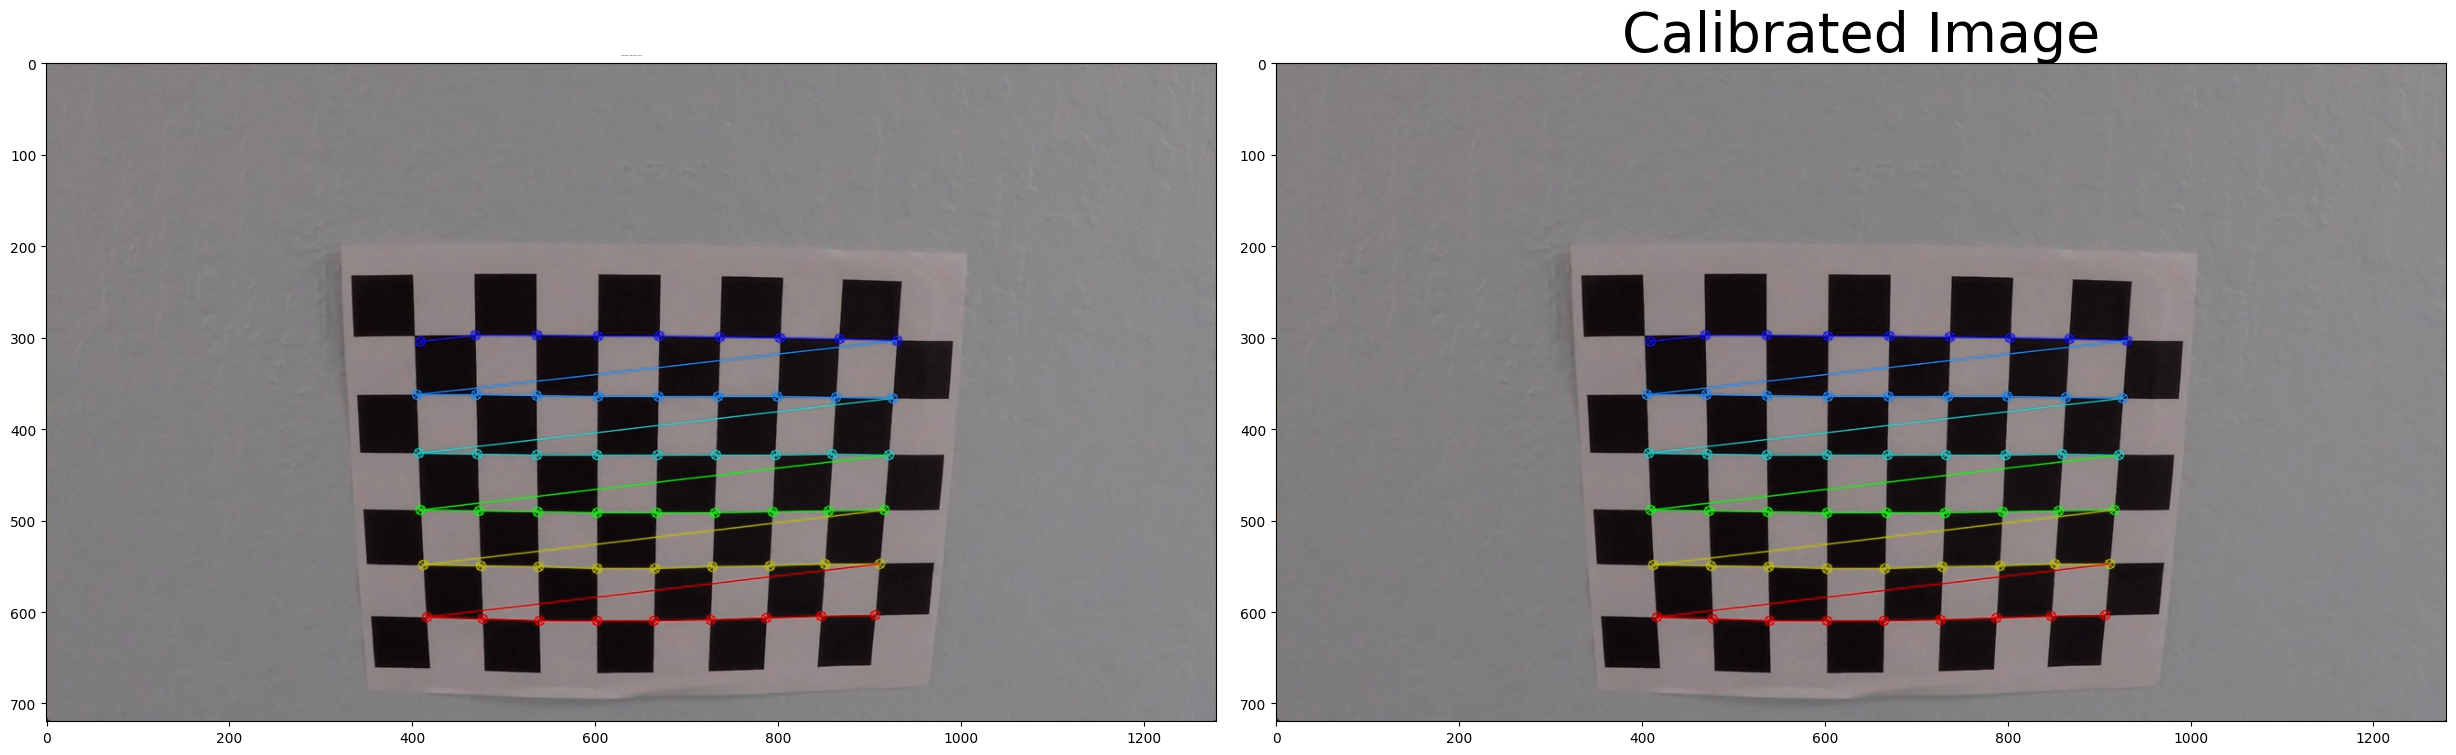

In [3]:
img2 = cv2.imread('./output_images/calibration17.jpg')
img = cv2.imread('./output_images/calibration17.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Chessboard Calibration Image', fontsize=0)
ax2.imshow(img2)
ax2.set_title('Calibrated Image', fontsize=40)
plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)

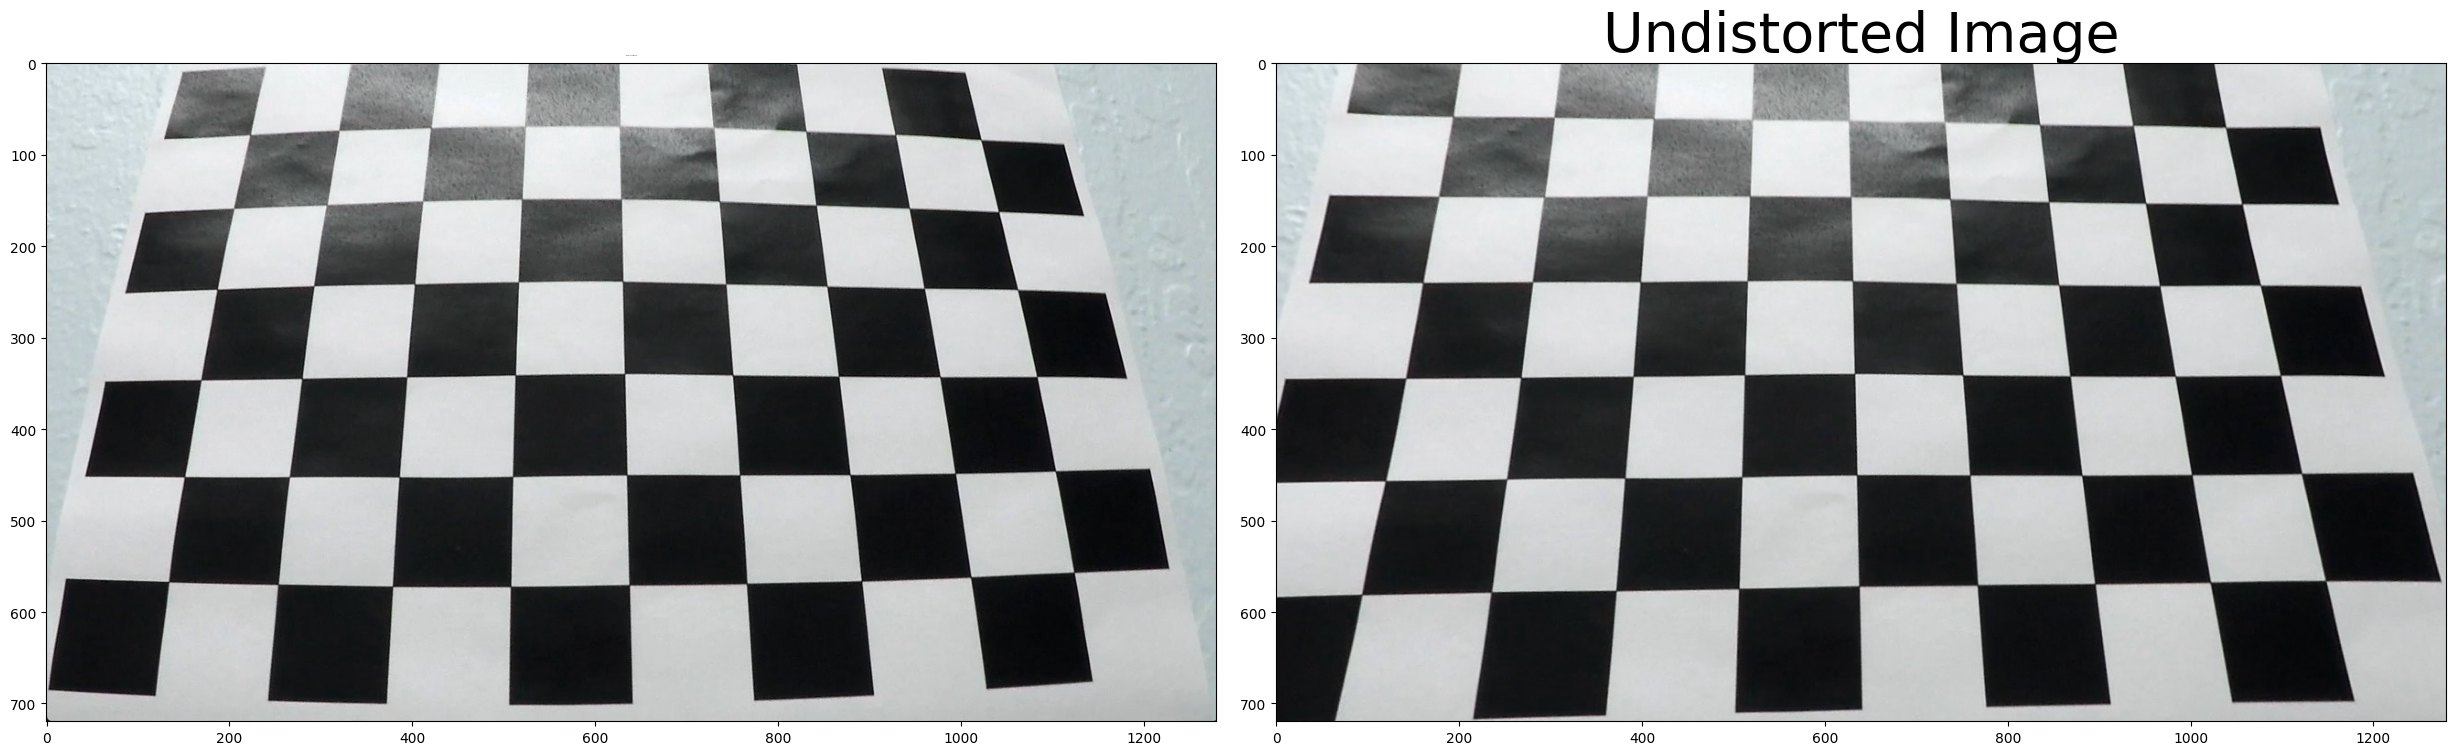

In [4]:
img = cv2.imread('./camera_cal/calibration3.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Distorted Image', fontsize=0)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)

(1280, 720)


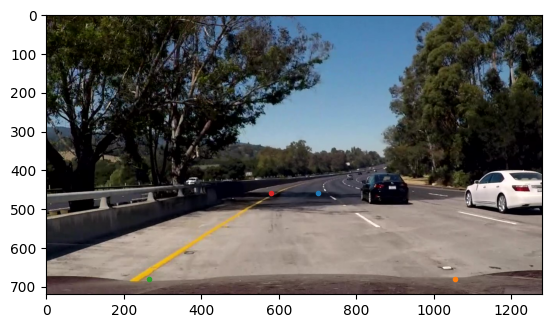

In [5]:
BGR_img = cv2.imread('test_images/moment41.jpg')
img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])
plt.imshow(img)
plt.plot(701, 459, '.')
plt.plot(1055, 680, '.')
plt.plot(265, 680, '.')
plt.plot(580, 459, '.')
print(img_size)

In [6]:
nx=9
ny=6

def warp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    offset = 300
    src = np.float32([(701,459),
                      (1055,680),
                      (265,680),
                      (580, 459)])
    dst = np.float32([(img_size[0]-offset,0),
                      (img_size[0]-offset,img_size[1]),
                      (img_size[0]-img_size[0]+offset,img_size[1]),
                      (img_size[0]-img_size[0]+offset,0)])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(undist,M,img_size)
    return warped, M, Minv

In [7]:
warped,M,Minv = warp(img,nx,ny,mtx,dist)

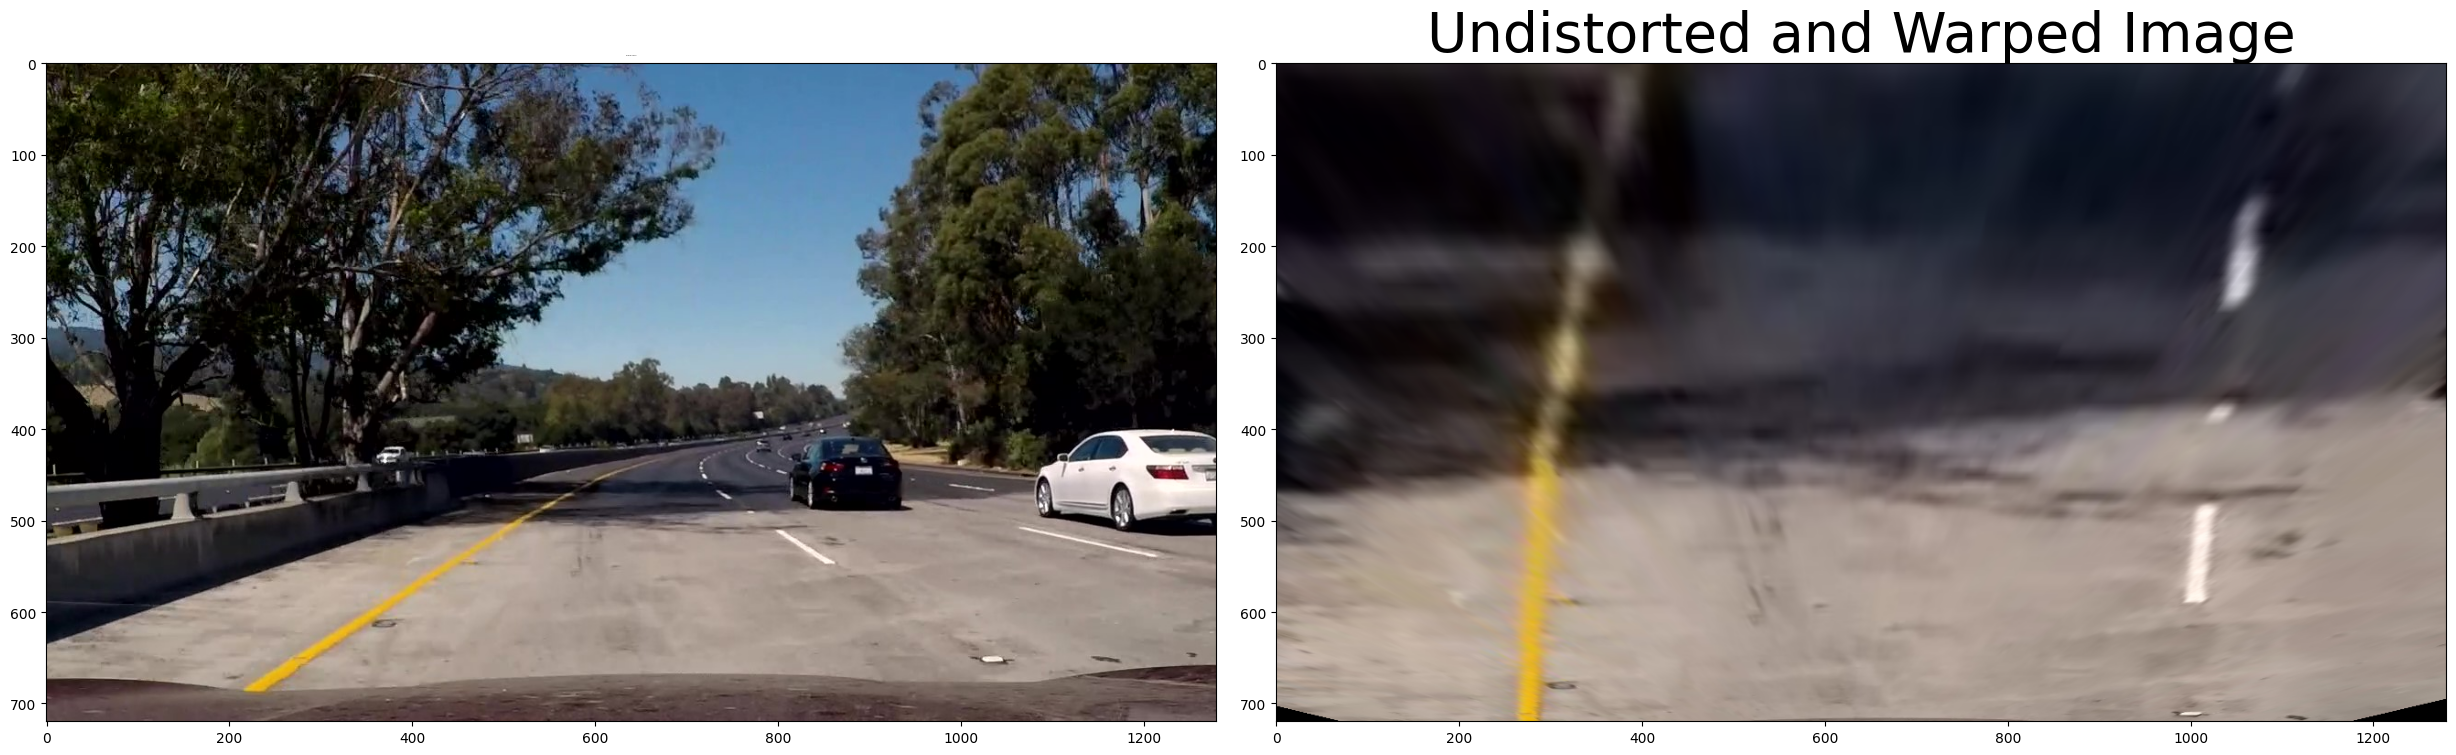

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=0)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)

In [9]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    if orient=='y':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    thresh_min = 20
    thresh_max = 200
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)]  = 1
    return sbinary

gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255)

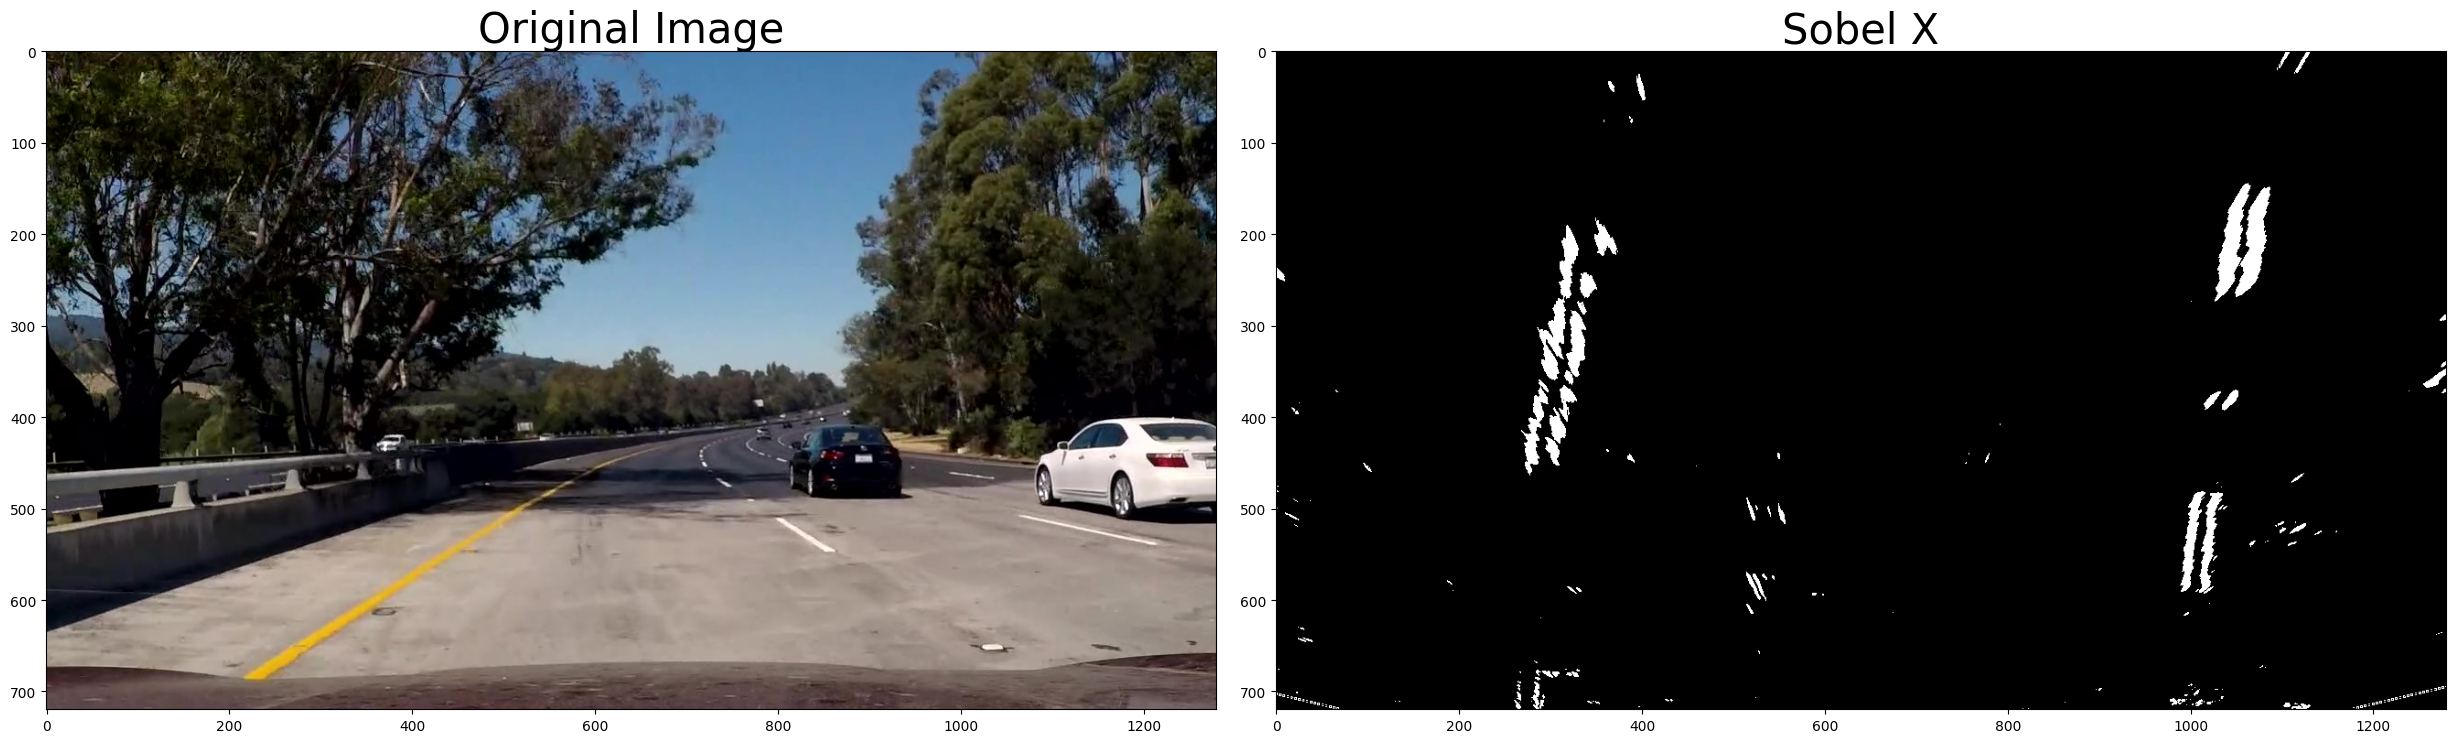

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(gradx,cmap='gray')
ax2.set_title('Sobel X', fontsize=30)
plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)

In [12]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output